In [37]:
from pandas import read_csv,DataFrame,read_excel, merge,concat, Series
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [38]:
datacsv          = "peru_ap17/"
datacsvcoffee    = "coffee_peru/"
data_peru        = "country_data/"
list_csv         = os.listdir(datacsvcoffee)

In [39]:
baseline = read_csv(datacsv+"OD_baseline_Peru.csv")
baseline.index = baseline.Name
baseline["O"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))
baseline["D"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(2))

In [40]:
figures = "figures_august/"
if not os.path.exists(figures):
    os.makedirs(figures)

### calculates weights for each node

In [41]:
nodes1 = read_excel(data_peru+"NODE_CID.xlsx","NODES_CID")
nodes2 = read_excel(data_peru+"NODES_10km_TPDA.xlsx","NODES_10km_TPDA")

nodes = merge(nodes1, nodes2, on='CID', how='outer')

#### the function below calculates the weight of a OD pair based on the gravity model

In [42]:
baseline["Ot"] = baseline.O.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Dt"] = baseline.D.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Opop"] = baseline.O.replace(nodes.set_index('CID')["Population Headcount"])
baseline["Dpop"] = baseline.D.replace(nodes.set_index('CID')["Population Headcount"])

In [43]:
baseline.ix[baseline.Total_KM!=0,'weights']=baseline.ix[baseline.Total_KM!=0,'Ot']\
                                            *baseline.ix[baseline.Total_KM!=0,'Dt']\
                                            /baseline.ix[baseline.Total_KM!=0,'Total_KM']**2
baseline.weights.fillna(0,inplace=True)

In [44]:
info_links = read_excel(data_peru+"Traffic_Link_Final_PER_jun03.xlsx","Traffic_Link_Final")
info_links_coffee = read_csv(datacsvcoffee+"Paita_Yurimaguas.csv")

In [45]:
costs_all = DataFrame(columns=["rp","ruc_increase","missingroutes",\
                           "num_aff_routes","cost_with_traffic","km_diff"])
for file in list_csv:
    if ".csv" not in file:
        continue
    if "scenario" not in file:
        continue

    aa      = re.search('scenario_coffee_(.*).csv', file)
    event   = aa.group(1)
    if "rp" in event:
        rp=float(event.replace("rp",""))
    else:
        rp=event

    scenar = read_csv(datacsvcoffee+file)
    scenar.index = scenar.Name

    missingroutes = len(baseline)-len(scenar)
    # we do not take into account the routes that don't have a second best solution
    baseline_nm = baseline.ix[[i in scenar.index for i in baseline.index],:]
    # we select only routes that get affected by the disruption
    affected_routes = (np.round(scenar.Total_Ta_r/baseline_nm.Total_Ta_r,3)!=1)&(baseline_nm.Total_Ta_r>0)
    subscenar = scenar.ix[affected_routes,:]
    subscenar["weights"] = baseline_nm.weights

    traffic = info_links_coffee.ix[:,"TPDA"].mean()

    diff_ruc_baseline   = (subscenar.Total_Ta_r-\
                           baseline_nm.ix[affected_routes,"Total_Ta_r"])
    diff_km_from_baseline = (subscenar.Total_KM-baseline_nm.ix[affected_routes,"Total_KM"])
    diff_tot_baseline   = (traffic*diff_ruc_baseline)

    ruc_increase      = np.sum(diff_ruc_baseline*subscenar.weights)/subscenar.weights.sum()
    km_diff = np.sum(diff_km_from_baseline*subscenar.weights)/subscenar.weights.sum()
    cost_with_traffic  = np.sum(diff_tot_baseline*subscenar.weights)/subscenar.weights.sum()

    costs_all.loc[len(costs_all),:] = [rp,\
                                       ruc_increase,missingroutes,sum(affected_routes),\
                                       cost_with_traffic,km_diff]

C:\Miniconda3\lib\site-packages\IPython\kernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
costs_all["time_diff"]=costs_all.km_diff/70

In [47]:
costs_all

,rp,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff,time_diff
0,huaycos,149.5891,360,1548,158021.9,96.29302,1.375615
1,10,111.4643,533,2618,117747.9,60.34827,0.8621181
2,100,101.9765,1043,2108,107725.3,61.27694,0.8753849
3,1000,101.9765,1043,2108,107725.3,61.27694,0.8753849
4,25,122.7108,533,2618,129628.4,66.91936,0.9559908
5,250,101.9765,1043,2108,107725.3,61.27694,0.8753849
6,5,117.3721,533,2130,123988.8,64.86011,0.926573
7,50,101.9765,1043,2108,107725.3,61.27694,0.8753849
8,500,101.9765,1043,2108,107725.3,61.27694,0.8753849


In [48]:
file = "scenario_coffee_rp50.csv"
scenar = read_csv(datacsvcoffee+file)
scenar.index = scenar.Name
missing_routes = [r not in scenar.Name for r in baseline.Name]

In [49]:
origins = baseline.ix[missing_routes,"Name"].apply(lambda s: re.search("(.*) - (.*)",s).group(1))

In [50]:
cuts = origins.value_counts()

In [51]:
cuts.head(6)

C164    91
C208    89
A2      89
C183    88
C188    88
C215    88
dtype: int64

In [52]:
air = read_csv("country_data/NODES_Peru_AIR.csv")
border = read_csv("country_data/NODES_Peru_BORDER.csv")
city = read_csv("country_data/NODES_Peru_CITY.csv")
port = read_csv("country_data/NODES_Peru_PORT.csv")

In [53]:
city.ix[[i in ["C164","C208","C188","C215","C183"] for i in city.CID],"CITY_NAME"]

1           Piura
20      Mayobamba
25    Chachapoyas
45        Iquitos
52          Rioja
Name: CITY_NAME, dtype: object

In [54]:
air.ix[[i in ["A2"] for i in air.CID],:]

,ID,Name,City,Country,IATA_FAA,ICAO,Y,X,Altitude,Timezone,...,CLD_RWY,HELAND_DIS,HE_TAKEOFF,LELAND_DIS,LE_TAKEOFF,RWY_CYCLE_,COUNTRY_1,ISO,AID,CID
1,2777,Alferez Vladimir Sara Bauer,Andoas,Peru,NaN,SPAS,-2.796128,-76.466617,728,-5,...,NaN,6749,6949,6749,6954,200513,Peru,PER,A2,A2


In [55]:
terrain_corr = read_csv("terrain_correspondance.csv")
info_links_coffee = info_links_coffee.merge(terrain_corr,on=["TERRAIN"],how="inner")

In [56]:
intervention_costs = read_csv("interventions_costs_usdperkm_sep1.csv")
info_links_coffee = info_links_coffee.merge(intervention_costs,on=["CLASS","SURFACE1","terrain2"],how="inner")

In [57]:
%load_ext autoreload
%autoreload
from functions_economic_analysis_el_nino import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
for rp in [5,10,25,50,100,250,500,1000]:
    col = "{} rp flood (dm)".format(rp)
    rehab = (info_links_coffee[col]<10)&(info_links_coffee[col]>0)
    cost = sum(info_links_coffee.ix[rehab,"KM"]*info_links_coffee.ix[rehab,"rehabilitation"])
    recons = (info_links_coffee[col]>=10)
    cost += sum(info_links_coffee.ix[recons,"KM"]*info_links_coffee.ix[recons,"construction"])
    costs_all.ix[costs_all.rp==rp,"expost"]=cost
    
col = "huaycos"
hua = info_links_coffee[col]==1
cost = sum(info_links_coffee.ix[hua,"KM"]*info_links_coffee.ix[hua,"construction"])
costs_all.ix[costs_all.rp=='huaycos',"expost"]=cost

In [61]:
costs_all.rename(columns={"RP":"rp"},inplace=True)

In [62]:
for rp in [5,10,25,50,100,250,500,1000]:
    col = "{} rp flood (dm)".format(rp)
    if sum(info_links_coffee[col]>=10)>0:
        cafeloss = 1.1*10**(6)
    if sum(info_links_coffee[col]>=20)>0:
        cafeloss = 10*1.1*10**(6)
    costs_all.ix[costs_all.rp==rp,"cafe"]=cafeloss
    
col = "huaycos"
hua = info_links_coffee[col]==1
costs_all.ix[costs_all.rp=='huaycos',"cafe"]=1.1*10**(6)

In [63]:
costs_all.rename(columns={"rp":"RP"},inplace=True)
costs_all

,RP,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff,time_diff,expost,cafe
0,huaycos,149.5891,360,1548,158021.9,96.29302,1.375615,6.537011e+08,1100000
1,10,111.4643,533,2618,117747.9,60.34827,0.8621181,4.360496e+08,11000000
2,100,101.9765,1043,2108,107725.3,61.27694,0.8753849,8.664468e+08,11000000
3,1000,101.9765,1043,2108,107725.3,61.27694,0.8753849,1.126912e+09,11000000
4,25,122.7108,533,2618,129628.4,66.91936,0.9559908,7.145026e+08,11000000
5,250,101.9765,1043,2108,107725.3,61.27694,0.8753849,1.117880e+09,11000000
6,5,117.3721,533,2130,123988.8,64.86011,0.926573,6.343201e+08,1100000
7,50,101.9765,1043,2108,107725.3,61.27694,0.8753849,8.637985e+08,11000000
8,500,101.9765,1043,2108,107725.3,61.27694,0.8753849,1.122681e+09,11000000


In [17]:
annual_losses(costs_all[1::],"expost")

122914533.47882605

In [64]:
def tot_annual_cost(costs_all,proba):
    user_losses = annual_losses(costs_all[1::],"cost_with_traffic")
    cafe_losses = annual_losses(costs_all[1::],"cafe")
    return user_losses+cafe_losses+proba*costs_all.loc[0,"cost_with_traffic"]+proba*costs_all.loc[0,"cafe"]

In [65]:
def change_proba(costs_all,proba):
    costs_all2 = costs_all.copy()
    costs_all2.loc[1::,"RP"]=costs_all2.loc[1::,"RP"]/proba
    if proba>1:
        costs_all2.loc[len(costs_all2),:]=costs_all.ix[costs_all.RP==1000,:].values[0]
    if proba>2:
        costs_all2.loc[len(costs_all2),:]=costs_all.ix[costs_all.RP==500,:].values[0]
    if proba>3:
        costs_all2.loc[len(costs_all2),:]=costs_all.ix[costs_all.RP==250,:].values[0]
    return costs_all2

In [66]:
tot_annual_cost(costs_all,1)

2987058.1033588201

In [67]:
tot_annual_cost(change_proba(costs_all,4),4)

11948232.41343528

In [22]:
from pyDOE import *

In [23]:
ranges = DataFrame(columns=["variable","min","max"])
ranges.loc[0,:]=["proba",1,4]
ranges.loc[1,:]=["disc_rate",0.03,0.2]
lhsample= lhs(len(ranges),samples=500,criterion="corr")
scenarios=lhsample*np.diff(ranges[['min','max']].values).T+ranges['min'].values
scenarios=DataFrame(scenarios,columns=ranges['variable'])

new candidate solution found with max,abs corrcoef = 1.0000000000000002


In [68]:
benef_redundancy3=DataFrame()
years=20
for i in scenarios.index:
    growth = 0.03
    [proba,disc_rate]=scenarios.loc[i,:].values
    disc_fact = np.array([1/(1+disc_rate)**i for i in range(1,years+1)])
    growth = np.array([(1+growth)**i for i in range(1,years+1)])
    temp = DataFrame(columns=['benef'])
    temp.loc[0,'benef'] = sum(np.array(years*[tot_annual_cost(change_proba(costs_all,proba),proba)])*disc_fact*growth)
    temp.ix[:,"disc_rate"]=disc_rate
    temp.ix[:,"proba"]=proba
    benef_redundancy3 = benef_redundancy3.append(temp,ignore_index=True)

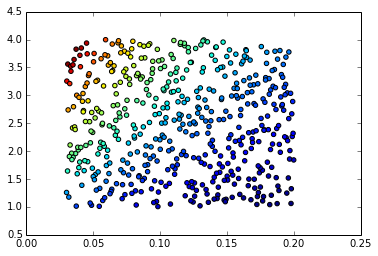

In [69]:
plt.scatter(benef_redundancy3.disc_rate,benef_redundancy3.proba,c=benef_redundancy3.benef)

In [70]:
benef_redundancy3.ix[benef_redundancy3.proba<2,'benef'].astype(float).describe()

count    1.670000e+02
mean     4.840551e+07
std      2.149684e+07
min      1.850386e+07
25%      3.214556e+07
50%      4.362382e+07
75%      5.943150e+07
max      1.125266e+08
Name: benef, dtype: float64